## This notebook is for an example of how to use XCast for making multimodel ensemble using Extreme Learning Machine methods for determinisitc and Probabilisitc  forecast.

Prediction surface temperature for this example using two NMME model and GCHN data as reference

Created by Nachiketa Acharya on Oct,2023

Reference:

Acharya et al., 2014;https://link.springer.com/article/10.1007/s00382-013-1942-2)

Acharya and Hall 2023:http://103.215.208.102/index.php/MAUSAM/article/view/5997



### Import Librarires

In [1]:
import xcast as xc 
import xarray as xr 
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Showing the version of XCast installed

In [2]:
xc.__version__

'0.6.9'

### Read downloded Observed data


Read your donwloded or own observed data. For example, I have donwloeded GCHN data(JJAS avaergare from 1982-2022 for 12-72N,60-170W)Y 
from IRI DL using the below link.However,anyone can donwloded data from any webpage
data downlowed from IRI data library link :https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GHCN_CAMS/.1x1_4822/.t2m/T/%28Jan%201982%29/%28Dec%202022%29/RANGE/T/%28Jun-Aug%29/seasonalAverage/Y/%2812N%29/%2872N%29/RANGEEDGES/X/%28170W%29/%2860W%29/RANGEEDGES/273/add/index.html#expert

In [3]:
obs = xr.open_dataset('GHCN_JJA_1982_2021.nc',decode_times=False).t2m.expand_dims({'M':[0]},axis=1)#As XCast handle only 4 dimesion data, we need to add one extra dimesion in Observed data. Here, we add "M" dimension in second axis. This is only for data downloded from IRI Data library as they have this issue
obs.dims

('T', 'M', 'Y', 'X')

### Read downloded NMME data

Read your donwloded NMME data from anywhere.For example, I have donwloeded GCHN data(lead -1,May Start JJAS avaergare from 1982-2022 for 12-72N,60-170W) from IRI DL using the below links.However,anyone can donwloded data from any webpage data downlowed from IRI data library link

data downlowed links :

CFS:https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/a:/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.tref/:a:/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.tref/:a/appendstream/S/%280000%201%20May%201982-2021%29/VALUES/L/0.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/%2812N%29/%2872N%29/RANGEEDGES/X/%28170W%29/%2860W%29/RANGEEDGES/M/%281%29/%2824%29/RANGE/%5BM%5Daverage/index.html#expert


In [4]:
model1 = xr.open_dataset('CFSv2_MayIC_JJA_1982_2021_tref.nc',decode_times=False).tref

model1= model1.rename({'L':'M'})
#model1.dims

model2 = xr.open_dataset('CCSM4_MayIC_JJA_1982_2021_tref.nc',decode_times=False).tref.squeeze('Z')# it has extra Z axis

model2= model2.rename({'L':'M'})
#model2.dims

predictor_names=['CFSv2','CCSM4']

Model = xr.concat([model1,model2], 'M').assign_coords({'M': predictor_names})
Model.dims


('S', 'M', 'Y', 'X')

### Match the resolution of Model and Observed data

In [5]:
Model,obs = xc.match(Model,obs)

### MME fitting with Extreem Learning Machine and Probabilisitc Extreem Learning Machine

#### define hyperparameter

In [6]:
elm_kwargs = {
            'regularization': 10,
            'hidden_layer_size': 10,
            'activation': 'lin',# 'sigm', 'tanh', 'lin', 'leaky', 'relu', 'softplus'],
            'preprocessing':'std',#minmax', 'std', 'none' ],
            'n_estimators': 100,
}
    

#### Run fitting

In [7]:
hindcasts_det, hindcasts_prob = [], []
i=1
for xtrain, ytrain, xtest, ytest in xc.CrossValidator(Model, obs, window=1):
    print("window {}".format(i))
    i += 1
    reg = xc.ELM(**elm_kwargs)
    reg.fit(xtrain, ytrain)
    preds = reg.predict(xtest)
    probs =  reg.predict_proba(xtest)
    hindcasts_det.append(preds.isel(S=0))
    hindcasts_prob.append(probs.isel(S=0))
hindcasts_det = xr.concat(hindcasts_det, 'S')
hindcasts_prob = xr.concat(hindcasts_prob, 'S')

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 33
window 34
window 35
window 36
window 37
window 38
window 39
window 40


#### Smooth the hindcast and observed data 

In [8]:
hindcasts_det=xc.gaussian_smooth(hindcasts_det, kernel=9)
obs=xc.gaussian_smooth(obs, kernel=9)

#### Saving a 4d netcdf data

In [ ]:
MME_temp_JJA=hindcasts_det.squeeze('M')
#repaet 6 times for making fake members
MME_temp_JJA_hindcasts = xr.concat([MME_temp_JJA,MME_temp_JJA,MME_temp_JJA,MME_temp_JJA,MME_temp_JJA,MME_temp_JJA],'D')
MME_temp_JJA_hindcasts=MME_temp_JJA_hindcasts.transpose('X','Y','S','D')
MME_temp_JJA_hindcasts.name = 'hindcast'
#hindcast_JJA = hindcast_JJA.assign_coords({'D': [i for range(6)]})
MME_temp_JJA_hindcasts = MME_temp_JJA_hindcasts.rename({'X': 'longitude', 'Y': 'latitude'})

MME_temp_JJA_hindcasts.to_netcdf('hindcast_JJA_MME_tref.nc') 


### Calculate skill metircs

#### Pearson Correlation

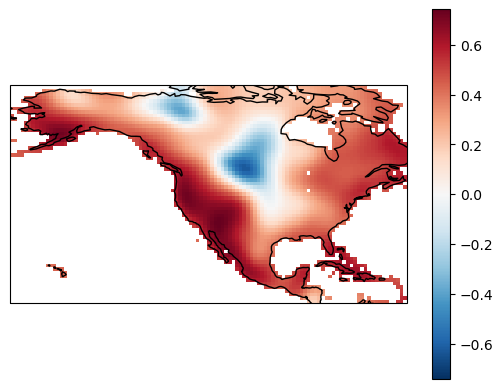

In [22]:
pearson = xc.Pearson(hindcasts_det, obs)
pearson=pearson.expand_dims({'M':[0],'T':[0]})
pearson=xc.gaussian_smooth(pearson, kernel=9).mean('M').mean('T')
pl = pearson.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()

#### Kling Gupta Efficiency

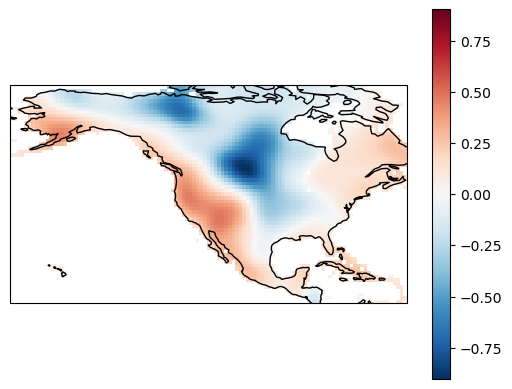

In [10]:
KGE = xc.KlingGuptaEfficiency(hindcasts_det, obs)
KGE=KGE.expand_dims({'M':[0],'T':[0]})
KGE=xc.gaussian_smooth(KGE, kernel=9).mean('M').mean('T')
pl = KGE.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()

#### Root Mean Square Error

RMSE is not the function in XCast, so we need to define follwoing way

In [11]:
import numpy as np
from xcast import metric 

# this is the 2-dimensional function which calculates the RMSE between two NumPy Column Vectors.
# we also just extend this using the @metric decorator from the start

@metric
def XCastRMSE(x, y): 
    squared_error = (x - y)**2 
    mean_squared_error = squared_error.mean() 
    return np.sqrt(mean_squared_error) 

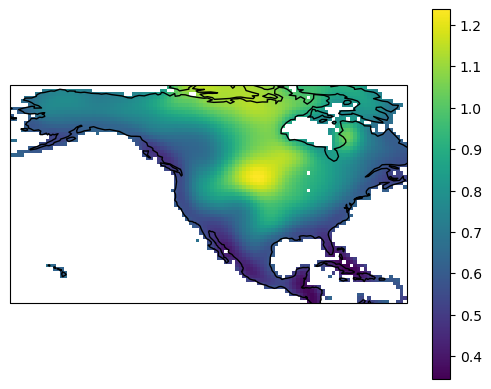

In [12]:
RMSE = XCastRMSE(hindcasts_det, obs)
RMSE=RMSE.expand_dims({'M':[0],'T':[0]})
RMSE=xc.gaussian_smooth(RMSE, kernel=9).mean('M').mean('T')
pl = RMSE.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()

#### Rank Probability Skill Score

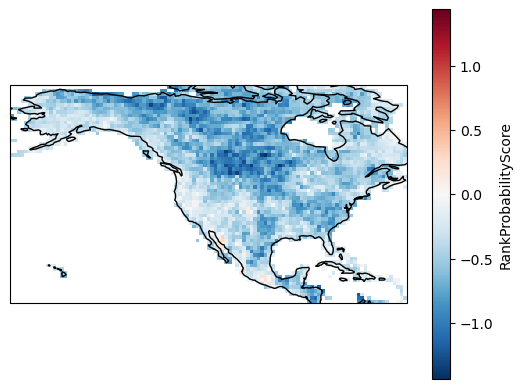

In [13]:

ohc = xc.OneHotEncoder() 
ohc.fit(obs)
T = ohc.transform(obs)
clim = xr.ones_like(T) * 0.333

clim_rps = xc.RankProbabilityScore(clim, T)
pred_rps = xc.RankProbabilityScore(hindcasts_prob, T)
rpss = 1 - pred_rps / clim_rps

pl = rpss.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()


#### Generalized ROC

In [15]:
groc=xc.GROCS(hindcasts_prob, T)

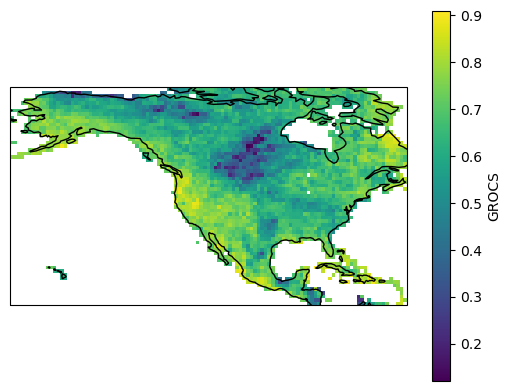

In [17]:
pl = groc.plot(subplot_kws={'projection': ccrs.PlateCarree()})
c = pl.axes.coastlines()


#### Reliability diagram and ROC plot

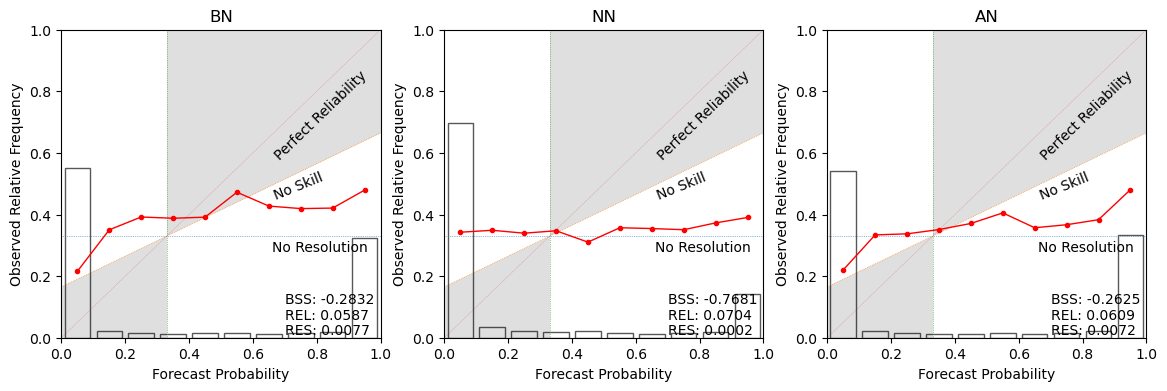

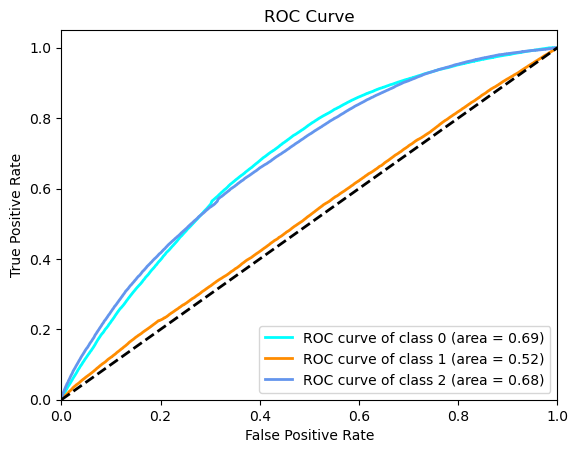

In [20]:
xc.view_reliability( hindcasts_prob, T )
xc.view_roc( hindcasts_prob, T )